In [35]:
import json
from tqdm import tqdm,trange
import numpy as np
import pandas as pd
import torch
from pyexpat import model
import os
import argparse
from scipy.stats import spearmanr,pearsonr,kendalltau
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
# /nfsdata/laip/results/valid/Llama-3___1-Tulu-3-8B_logits.json
# /nfsdata/laip/results/valid/Mistral-7B-Instruct-v0___3_logits.json
# /nfsdata/laip/results/valid/Meta-Llama-3___1-8B-Instruct_logits.json
# /nfsdata/laip/results/valid/internlm3-8b-instruct_logits.json

# /home/laip/InternalScore/results/valid/Llama-3___1-Tulu-3-8B_with_feedback_logits.json
# /home/laip/InternalScore/results/valid/Mistral-7B-Instruct-v0___3_with_feedback_logits.json
# /home/laip/InternalScore/results/valid/Meta-Llama-3___1-8B-Instruct_with_feedback_logits.json
# /home/laip/InternalScore/results/valid/internlm3-8b-instruct_with_feedback_logits.json


data_path = '/nfsdata/laip/results/valid/Meta-Llama-3___1-8B-Instruct_logits.json'
data = json.load(open(data_path))
# with open(data_path) as f:
#     data = [json.loads(line) for line in f]

In [36]:
import json
from tqdm import tqdm,trange
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import random
random.seed(56)

def optimize_layer_weights(logits_list, targets, loss_fn, num_epochs=2, lr=0.01,min_lr = 1e-3):
    all_res=  []
    L = len(logits_list[0])  
    random.shuffle(logits_list)
    
    # 初始化权重
    weights = torch.nn.Parameter(torch.ones(L, requires_grad=True))
    optimizer = optim.Adam([weights], lr=lr)

    for epoch in trange(num_epochs):
        total_loss = 0

        for sample_idx in trange(len(logits_list)):  # 遍历所有样本
            logits = logits_list[sample_idx]  
            target = targets[sample_idx]  

            if type(loss_fn) == torch.nn.modules.loss.CrossEntropyLoss:
                target = target - 1
                target = torch.tensor(target,dtype=torch.long)

            normalized_weights = torch.softmax(weights, dim=0)

            # 计算加权和
            weighted_sum = torch.zeros_like(logits[0])  
            for l in range(L):
                if type(loss_fn) == torch.nn.modules.loss.CrossEntropyLoss:
                    weighted_sum += normalized_weights[l] * logits[l]  # logits累积加权
                    predictions = weighted_sum
                else:
                    weighted_sum += normalized_weights[l] * (torch.tensor(logits[l])*torch.tensor([1,2,3,4,5])).sum()  # 加权求和
                    predictions = weighted_sum  # 预测结果


            loss = loss_fn(predictions,target)

            total_loss += loss.item()
            all_res.append(total_loss/(sample_idx+1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()

        # 每个 epoch 打印损失
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}")

    return torch.softmax(weights, dim=0).detach(),all_res


In [37]:

# import json
# from tqdm import tqdm,trange
# import numpy as np
# import pandas as pd
# import torch
# import torch.optim as optim
# import torch.nn as nn
# all_loss = []
# def optimize_layer_weights(logits_list, targets, loss_fn1,loss_fn2, num_epochs=4, lr=0.01 , add_loss = True):

#     L = len(logits_list[0])  

#     # 初始化权重
#     weights = torch.nn.Parameter(torch.randn(L, requires_grad=True))
#     beta = torch.nn.Parameter(torch.tensor(1, requires_grad=True,dtype=torch.float32))
#     alpha = torch.nn.Parameter(torch.tensor(0, requires_grad=True,dtype=torch.float32))
#     bias = torch.nn.Parameter(torch.tensor(0, requires_grad=True,dtype=torch.float32))
#     # weights = torch.zeros(L)
#     # weights[-1] = 1
#     # weights = torch.nn.Parameter(weights,requires_grad=True)

#     optimizer = optim.Adam([weights,beta,alpha,bias], lr=lr)

#     for epoch in trange(num_epochs):
#         total_loss = 0

#         for sample_idx in trange(len(logits_list)):  # 遍历所有样本
#             logits = logits_list[sample_idx]  
#             target = targets[sample_idx]  

#             target1 = target - 1
#             target1 = torch.tensor(target1,dtype=torch.long)
#             target2 = target

#             normalized_weights = torch.softmax(weights, dim=0)

#             # 计算加权和
#             weighted_sum1 = torch.zeros_like(logits[0])  
#             weighted_sum2 = torch.tensor(0,dtype = torch.float32)

#             for l in range(L):
                
#                 weighted_sum1 += normalized_weights[l] * logits[l]  # logits累积加权
#                 weighted_sum2 += (normalized_weights[l] * (torch.tensor(logits[l]).softmax(dim=-1)*torch.tensor([1,2,3,4,5])).sum()).sum()  # 加权求和
                
#             predictions1 = weighted_sum1
#             predictions2 = beta*weighted_sum2.sum()+bias  # 预测结果

#             alpha_norm = torch.sigmoid(alpha)
#             loss = loss_fn1(predictions1,target1) +alpha_norm*loss_fn2(predictions2,target2)
            
#             total_loss += loss.item()
#             all_loss.append(total_loss/(sample_idx+1))


#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         avg_loss = total_loss / len(logits_list)
#         # 每个 epoch 打印损失
#         print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

#     return torch.softmax(weights, dim=0).detach(),beta.detach(),bias.detach(),all_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import trange
import numpy as np

def optimize_layer_weights1(
    logits_list,
    targets,
    loss_fn1,
    loss_fn2,
    num_epochs=4,
    batch_size=32,
    lr=0.02,
    min_lr=1e-4,
    device="cpu"
):
    """带余弦退火学习率调度和批量训练的优化版本"""
    # 数据预处理 -------------------------------------------------
    # 转换为张量并确保设备一致性
    L = len(logits_list[0])
    num_classes = len(logits_list[0][0])
    
    # 将输入数据转换为张量 [num_samples, L, num_classes]
    logits_tensor = torch.tensor(logits_list,device=device)
    targets = torch.tensor(targets, dtype=torch.long, device=device)
    
    # 转换目标张量
    
    targets_reg = torch.tensor(targets, dtype=torch.float32, device=device)
    
    # 系数张量
    coefficients = torch.tensor([1.,2.,3.,4.,5.], device=device)
    
    # 参数初始化 -------------------------------------------------
    weights = nn.Parameter(torch.ones(L, device=device))
    beta = nn.Parameter(torch.tensor(1.0, device=device))
    alpha = nn.Parameter(torch.tensor(1.0, device=device))
    bias = nn.Parameter(torch.tensor(0.5, device=device))
    
    # 优化器和调度器 ---------------------------------------------
    #optimizer = optim.Adam([weights, beta, alpha, bias], lr=lr)
    optimizer = optim.Adam([weights], lr=lr)

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=min_lr)
    
    # 训练循环 ---------------------------------------------------
    all_losses = []
    num_samples = len(logits_list)
    
    for epoch in trange(num_epochs, desc="Epochs"):
        # 随机打乱数据
        indices = torch.randperm(num_samples)
        epoch_loss = 0.0
        
        for batch_start in range(0, num_samples, batch_size):
            # 获取当前batch
            batch_indices = indices[batch_start : batch_start+batch_size]
            batch_logits = logits_tensor[batch_indices]  # [B, L, C]
            batch_cls_targets = targets[batch_indices]-1
            batch_reg_targets = targets_reg[batch_indices]
            
            # 前向传播 -------------------------------------------
            normalized_weights = torch.softmax(weights, dim=0)
            
            # 分类预测 [B, C]
            cls_pred = torch.einsum('l,blc->bc', normalized_weights, batch_logits)
            
            # 回归预测计算
            # 1. 计算每个样本每层的得分 [B, L]
            layer_scores = torch.softmax(batch_logits, dim=-1) @ coefficients
            # 2. 加权求和 [B]
            reg_pred = beta * (layer_scores @ normalized_weights) + bias
            
            # 损失计算 -------------------------------------------
            alpha_norm = torch.sigmoid(alpha)
            loss_cls = loss_fn1(cls_pred, batch_cls_targets)
            loss_reg = loss_fn2(reg_pred, batch_reg_targets)
            #total_loss = alpha_norm * loss_cls + (1 - alpha_norm) * loss_reg
            total_loss = loss_cls
            
            # 反向传播 -------------------------------------------
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            # 记录损失
            all_losses.append(total_loss.item())
            epoch_loss += total_loss.item()
        
        # 更新学习率
        scheduler.step()
        
        # 打印统计信息
        avg_loss = epoch_loss / (num_samples // batch_size + 1)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")

    return (
        torch.softmax(weights, dim=0).detach(),
        beta.detach(),
        bias.detach(),
        all_losses
    )

In [38]:
human_score_ls = []
logits_ls = []
human_score_ls1 = []

weighted_score_ls = []
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()

for data1 in data:
    df = pd.DataFrame(data1['df'])
    if data1['weighted_socre']==-1:
        continue
    _logits = torch.tensor([i for i in df['logits']],dtype=torch.float32)
    #_logits = [i for i in df['logits']]
    human_score_ls1.append(data1['human_score'])
    if type(loss_fn) == torch.nn.modules.loss.CrossEntropyLoss:
        human_score = torch.tensor(data1['human_score'],dtype=torch.long)
        
    else:
        human_score = torch.tensor(data1['human_score'],dtype=torch.float32)

    weighted_score = torch.tensor(df['weighted_score'].to_list(),dtype=torch.float32)
    human_score_ls.append(human_score)
    logits_ls.append(_logits)
    weighted_score_ls.append(weighted_score)
# for data1 in data:
#     df = pd.DataFrame(data1['res'])
#     if data1['pred_score']['weighted_socre']==-1:
#         continue
#     _logits = torch.tensor([i for i in df['logits']],dtype=torch.float32)

#     if type(loss_fn) == torch.nn.modules.loss.CrossEntropyLoss:
#         human_score = torch.tensor(int(data1['human']),dtype=torch.long)
#     else:
#         human_score = torch.tensor(int(data1['human']),dtype=torch.float32)

#     weighted_score = torch.tensor(df['weighted_score'].to_list(),dtype=torch.float32)
#     human_score_ls.append(human_score)
#     logits_ls.append(_logits)
#     weighted_score_ls.append(weighted_score)

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch [1/1], Loss: 1604.9973
学习到的权重： tensor([0.0517, 0.0506, 0.0500, 0.0540, 0.0480, 0.0429, 0.0282, 0.0408, 0.0402,
        0.0423, 0.0540, 0.0499, 0.0479, 0.0590, 0.0576, 0.0458, 0.0537, 0.0324,
        0.0187, 0.0210, 0.0218, 0.0157, 0.0135, 0.0188, 0.0053, 0.0045, 0.0044,
        0.0053, 0.0043, 0.0043, 0.0041, 0.0039, 0.0052])


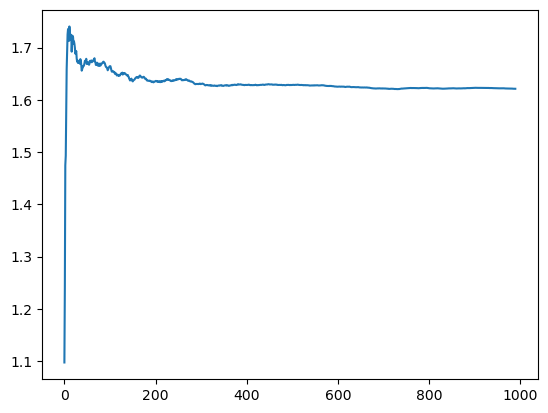

In [39]:
# weights,beta,bias,all_loss = optimize_layer_weights(
#                                         logits_ls, 
#                                         torch.tensor(human_score_ls1), 
#                                         loss_fn1 = nn.CrossEntropyLoss(),
#                                         loss_fn2=nn.MSELoss(),
#                                         num_epochs=10, 
#                                         batch_size = 128,
#                                         lr=0.0001,
#                                         min_lr=1e-4,
#                                         )
weights,all_loss = optimize_layer_weights(logits_ls, human_score_ls, nn.CrossEntropyLoss(),num_epochs=1, lr=0.01)

print("学习到的权重：", weights)
weights = weights.numpy()
import matplotlib.pyplot as plt

plt.plot(all_loss)

In [40]:
weights

array([0.05170907, 0.05060843, 0.05004781, 0.05398959, 0.04801609,
       0.04292724, 0.02820304, 0.04084966, 0.04022837, 0.04226979,
       0.05401829, 0.04989972, 0.04789615, 0.05896118, 0.05761898,
       0.04576585, 0.05368108, 0.03242693, 0.01874143, 0.02099193,
       0.02184623, 0.01572761, 0.01349316, 0.01882451, 0.00527081,
       0.00449068, 0.00435522, 0.00530916, 0.00433462, 0.0043277 ,
       0.00408142, 0.00392742, 0.00516077], dtype=float32)

In [41]:

def calc_corr(pred_score, score_type,human_score,type_r = 'pearson' ):
    r_ls = ['pearson','spearman','kendalltau']
    with open(f'predscore_{score_type}.json','w') as f:
        json.dump(pred_score,f)
    if type_r not in r_ls:
        raise ValueError('type_r must be one of {}'.format(r_ls))
    elif type_r == 'pearson':
        r = pearsonr(pred_score, human_score)[0]
    elif type_r == 'kendalltau':
        r = kendalltau(pred_score, human_score)[0]
    else:
        r = spearmanr(pred_score, human_score)[0]
    return r

def print_correlations(all_score_dict,human_score):
    metrics = ['pearson','spearman','kendalltau']   
    scores = ['direct_score','weighted_score','weighted_direct_score','internalscore','pre_score1','pre_score3','pre_score2','pre_score4']
    table = PrettyTable(['score_type']+metrics)
    for score in scores:
        add_row = [score] +[round(calc_corr(all_score_dict[score],score_type=score,human_score=human_score,type_r = 'pearson'),3),
                            round(calc_corr(all_score_dict[score],score_type='',human_score=human_score,type_r = 'spearman'),3),
                            round(calc_corr(all_score_dict[score],score_type='',human_score=human_score,type_r = 'kendalltau'),3)]
        table.add_row(add_row)
    print(table)

if 'tulu' in data_path.lower():
    model_name = 'Llama-3___1-Tulu-3-8B'
elif 'llama' in data_path.lower():
    model_name = 'Meta-Llama-3___1-8B-Instruct'
elif 'mistral' in data_path.lower():
    model_name = 'Mistral-7B-Instruct-v0___3'
elif 'internlm' in data_path.lower():
    model_name = 'internlm3-8b-instruct'
elif 'qwen' in data_path.lower():
    model_name = 'Qwen2___5-7B-Instruct'

#data_path = f'/home/laip/InternalScore/results/helpsteer/{model_name}_with_feedback_logits.json'
#data_path = f'/home/laip/InternalScore/results/helpsteer/{model_name}_logits.json'

#data_path = f'/home/laip/InternalScore/results/flask/{model_name}_with_feedback_logits.json'
data_path = f'/home/laip/InternalScore/results/flask/{model_name}_logits.json'
#data_path = '/home/laip/InternalScore/results/flask/Llama-2-7b-chat-hf_logits.json'
#data_path = '/home/laip/InternalScore/results/flask/Mistral-7B-Instruct-v0___2_logits.json'
all_human_score = []

all_res = json.load(open(data_path))
direct_score_ls = []
weighted_score_ls = []
weighted_direct_score_ls= []
internalscore_ls = []
save_ls = []
pre_score_ls1 = []
pre_score_ls2 = []
pre_score_ls3 = []
pre_score_ls4 = []
ratio = 0.9
cos = 0.02
score = np.array([[1,2,3,4,5] for i in range(pd.DataFrame(all_res[0]['df']).shape[0])])
final_score  = pd.DataFrame(score)


for i in range(len(all_res)):
    res = all_res[i]
    
    if res['weighted_socre'] == -1:
        continue
    all_human_score.append(res['human_score'])
    df = pd.DataFrame(res['df']) 
    score = np.array([1,2,3,4,5])

    # weighed_score 加权
    distribution1 = df['logits'].apply(lambda x:torch.tensor(x,dtype=torch.float32).softmax(dim=-1))
    pre_score1 = ((distribution1.apply(lambda x:(x*torch.tensor([1,2,3,4,5],dtype=torch.float32)).sum()))*weights).sum().item()

    # 累积logits 加权
    logits = df['logits'].apply(lambda x:torch.tensor(x,dtype=torch.float32))
    distribution2 = (logits).apply(lambda x:torch.tensor(x,dtype=torch.float32).argmax(dim=-1))
    pre_score = ((torch.tensor([ i+1 for i in distribution2]))*weights).sum().item()

    distribution2 = torch.softmax((logits*weights).sum(),dim=-1)
    pre_score2 = ((distribution2*torch.tensor([1,2,3,4,5],dtype=torch.float32)).sum()).item()
    #print(pre_score2)
    #pre_score2 = torch.argmax(distribution2).item()+1

    # 累积logits 不加权    
    distribution3 = torch.softmax((logits/weights.shape[0]).sum(),dim=-1)
    pre_score3 = (distribution3*torch.tensor([1,2,3,4,5],dtype=torch.float32)).sum().item()

    # ratio + cosine similarity 筛选
   # logits = df[(df['ratio']>ratio)&(df['weights']>cos)]['logits'].apply(lambda x:torch.tensor(x,dtype=torch.float32))
    logits = df[(df['ratio']>ratio)]['logits'].apply(lambda x:torch.tensor(x,dtype=torch.float32))
    distribution4 = torch.softmax((logits/logits.shape[0]).sum(),dim=-1)
    pre_score4 = (distribution4*torch.tensor([1,2,3,4,5],dtype=torch.float32)).sum().item()

    prompt = res['prompt']
    direct_score_ls.append(res['direct_socre'])
    weighted_score_ls.append(res['weighted_socre'])
    weighted_direct_score_ls.append(res['weighted_direct_socre'])
    internalscore_ls.append(res['internalscore'])
    pre_score_ls1.append(pre_score1)
    pre_score_ls2.append(pre_score2)
    pre_score_ls3.append(pre_score3)
    pre_score_ls4.append(pre_score)
    
    #internalscore_ls.append((df['weighted_score']*weights).sum())
#print(df[df['ratio']>r].shape[0])
print(len(all_human_score),len(direct_score_ls),len(weighted_score_ls),len(weighted_direct_score_ls),len(internalscore_ls),len(pre_score_ls1))
all_score_dict = {'direct_score':direct_score_ls,
                  'weighted_score':weighted_score_ls,
                  'weighted_direct_score':weighted_direct_score_ls,
                  'internalscore':internalscore_ls,
                  'pre_score1':pre_score_ls1,
                  'pre_score2':pre_score_ls2,
                  'pre_score3':pre_score_ls3,
                  'pre_score4':pre_score_ls4
                  }


print_correlations(all_score_dict,all_human_score)


FileNotFoundError: [Errno 2] No such file or directory: '/home/laip/InternalScore/results/flask/Meta-Llama-3___1-8B-Instruct_logits.json'

In [ ]:
def cal_abs(x,y):
    x = np.array(x)
    y = np.array(y)
    return (np.abs(x-y)/len(x)).sum()
cal_abs(pre_score_ls2,all_human_score)

1.064607928902617

In [ ]:
direct_score_ls 
all_human_score
pre_score_ls2
pre_score_ls3
data_name1 = 'direct_score'
with open(f'{data_name1}.json','w') as f:
    json.dump(direct_score_ls,f)
data_name2 = 'human_score'
with open(f'{data_name2}.json','w') as f:
    json.dump(all_human_score,f)
data_name3 = 'palmscore_w_tuning'
with open(f'{data_name3}.json','w') as f:
    json.dump(pre_score_ls3,f)

In [ ]:
cnt =0
for i in range(1,7):
    for j in range(1,7):
        if i**2==4*j:
            cnt+=1
cnt

2

In [ ]:
def transpose_matrix(a: list[list[int|float]]) -> list[list[int|float]]:
	row_len,col_len = len(a),len(a[0])
	b = [[0]*row_len]*col_len
	for i in range(row_len):
		for j in range(col_len):
			b[j][i] = a[i][j]
		print(b)
	return b

In [ ]:
def reshape_matrix(a: list[list[int|float]], new_shape: tuple[int, int]) -> list[list[int|float]]:
	#Write your code here and return a python list after reshaping by using numpy's tolist() method
	row_len,col_len = new_shape[0],new_shape[1]
	all_data = []
	for i in range(len(a)):
		for j in range(len(a[0])):
			all_data.append(a[i][j])
	reshaped_matrix = [[0]*col_len for _ in range(row_len)]
	for i in range(row_len):
		for j in range(col_len):
			reshaped_matrix[i][j] = all_data[i*col_len+j]
	return reshaped_matrix

1.3132616875182228